In [2]:
import os
import sys
sys.path.append("..")
os.environ['MUJOCO_GL']='egl'


from envs.maze_envs import CustomPointUMazeSize3Env
env = CustomPointUMazeSize3Env(render_mode='rgb_array')
episode_limit = 1000
env.reset()

array([-0.02931643, -0.03279223, -0.08697738,  0.07014061,  0.09452791,
        0.09523319,  0.        ])

(-0.5, 479.5, 479.5, -0.5)

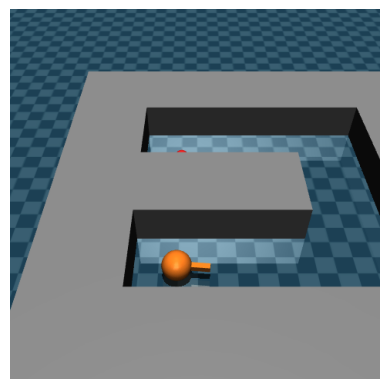

In [10]:
import matplotlib.pyplot as plt

plt.imshow(env.render())
plt.axis('off')